## Set Up</span></div>

### Importing packages and establishing a connection with Reddit API

In [77]:
# Collect relevant content through the Reddit API.
import json
import praw

import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} textblob
# PRAW documentation:
#  https://praw.readthedocs.io/en/stable/code_overview/reddit_instance.html

Solving environment: done

## Package Plan ##

  environment location: /Users/rodolfovela/opt/anaconda3

  added / updated specs:
    - textblob


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    textblob-0.15.3            |             py_0         595 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         595 KB

The following NEW packages will be INSTALLED:

  textblob           conda-forge/noarch::textblob-0.15.3-py_0



textblob-0.15.3      | 595 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
# IMPORTANT: enter proper access credential in the config-file;
# follow instructions in reddit_credentials_verify.ipynb
import config_reddit

In [3]:
# establish an API connection and verify read-only access
reddit = praw.Reddit(user_agent=f"Exploration script by /u/{config_reddit.user_name}",
                     client_id=config_reddit.app_id,
                     client_secret=config_reddit.app_secret)
reddit.read_only

True

## Collecting Data

In [4]:
# choose a subreddit of interest
query_subreddit = 'formula1'

In [5]:
# decide how many top-"hot" posts to query
nposts = 50

In [6]:
# collect ids of the top posts within the chosen subreddit
post_ids = []
subreddit = reddit.subreddit(query_subreddit)
for p in subreddit.hot(limit = nposts):
    post_ids.append(p.id)
# check how many posts (submissions) were collected
len(post_ids)

50

In [7]:
# example post details
post_details = reddit.submission(id = post_ids[1])
print(post_details.title)
print(post_details.selftext)

2022 Hungarian Grand Prix - Post Qualifying Discussion
### ROUND 13: Hungary 🇭🇺

|FORMULA 1 MAGYAR NAGYDÍJ 2022|
|:-:|
|Fri 29 Jul - Sun 31 Jul|
|Budapest|

| Session | UTC |
| - | - |
| Free Practice 1 | Fri 12:00 |
| Free Practice 2 | Fri 15:00 |
| Free Practice 3 | Sat 11:00 |
| Qualifying | Sat 14:00 |
| Race | Sun 13:00 |

[Click here for start times in your area.](http://f1calendar.com/)

---

#### Hungaroring

**Length:** 4.381 km (2.722 mi)

**Distance:** 70 laps, 306.663 km (190.551 mi)

**Lap record:** 🇬🇧 Lewis Hamilton, Mercedes, 2020, 1:16.627

**2021 pole:** 🇬🇧 Lewis Hamilton, Mercedes, 1:15.419

**2021 fastest lap:** 🇫🇷 Pierre Gasly, AlphaTauri-Honda, 1:18.394

**2021 winner:** 🇫🇷 Esteban Ocon, Alpine-Renault

[](/resultsBegin)

---

####Qualifying results

|Pos.|No.|Driver|Team|Q1|Q2|Q3|Laps|
|:-:|:-:|:-|:-|:-|:-|:-|:-|
|1|63|George Russell|Mercedes|1:18.407|1:18.154|1:17.377|23|
|2|55|Carlos Sainz|Ferrari|1:18.434|1:17.946|1:17.421|22|
|3|16|Charles Leclerc|Ferrari|1:18

In [8]:
# decide how many top comments to query per post;
# NOTE: larger number of comments may dilute the content (irrelevant text)
ncomments = 10

In [9]:
# function to collect post data
def collect_post_data(post_id, ncomments, reddit):
    psubm = reddit.submission(id = post_id)
    pdata = {'id': post_id, 'title': psubm.title, 'text': psubm.selftext}
    
    # collect first- and second-level comments
    pcomm = []
    psubcomm = []
    psubm.comments.replace_more(limit = ncomments)
    for top_comment in psubm.comments:
        pcomm.append(top_comment.body)
        for lev2_comment in top_comment.replies:
            psubcomm.append(lev2_comment.body)
    
    # assemble the data together
    pdata['comments_lev1'] = pcomm
    pdata['comments_lev2'] = psubcomm
    
    return pdata

In [10]:
# collect information for each post
posts_all = [collect_post_data(pid, ncomments, reddit) for pid in post_ids]

In [11]:
# save collected data to json file
file_out = f"raw_post_comment_data.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(posts_all, indent=2))

## Analyzing Formule One posts

In [12]:
# Reddit data analysis task starter.
import html
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# First collect the data in json-file (follow reddit_collect_data.ipynb); specify file name here
fjson = 'raw_post_comment_data.json'

In [14]:
# read json file with collected posts and comments
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

50

In [15]:
# data record example
data[0]

{'id': 'wbrcdp',
 'title': 'Ask /r/formula1 Anything - Daily Discussion - 30 July 2022',
 'text': "#Welcome to the /r/formula1 Daily Discussion / Q&A thread.\n\nThis thread is a hub for general discussion and questions about Formula 1, that don't need threads of their own.\n\nAre you new to Formula 1? This is the place for you. Ever wondered why it's called a lollipop man? Why the cars don't refuel during pitstops? Or when Mika will be back from his sabbatical? Ask any question you might have here, and the community will answer.\n\nAlso make sure you check out our [guide for new fans](/r/formula1/wiki/newtof1), and our [FAQ for new fans](/r/formula1/wiki/faq).\n\nAre you a veteran fan, longing for the days of lollipop men, refueling during pitstops, and Mika Häkkinen? This is the place to introduce new fans to your passion and knowledge of the sport.\n\nRemember to keep it civil and welcoming! Gatekeeping within the Daily Discussion will subject users to disciplinary action.\n\nHave a 

In [16]:
# create pandas dataframe from post titles
# https://stackoverflow.com/a/43175477
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,Ask /r/formula1 Anything - Daily Discussion - ...
1,2022 Hungarian Grand Prix - Post Qualifying Di...
2,[Chris Medland] Here he comes... LATIFI GOES Q...
3,Nicholas Latifi team radio - 2022 Hungarian GP...
4,George Russell takes pole position for the 202...
5,2022 Hungarian Grand Prix - Free Practice 3 Re...
6,"Q3: RUSSELL ON POLE, Sainz P2, Leclerc P3"
7,2022 Hungarian Grand Prix - Qualifying Results
8,FP3: Charles Leclerc 360 spin
9,[Phillip Horton] Sessions topped in 2022: Nich...


In [17]:
# add columns from other data fields: combine comment and sub-comment text
df_posts['post_id'] = [p['id'] for p in data]
df_posts['text'] = [p['text'] for p in data]
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data]
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data]
df_posts

,title,post_id,text,comments_lev1,comments_lev2
0,Ask /r/formula1 Anything - Daily Discussion - ...,wbrcdp,#Welcome to the /r/formula1 Daily Discussion /...,Looks like its not going to rain during quali....,There is a massive rain front passing through ...
1,2022 Hungarian Grand Prix - Post Qualifying Di...,wbzfoy,### ROUND 13: Hungary 🇭🇺\n\n|FORMULA 1 MAGYAR ...,I do NOT understand Mercedes this year. Big br...,"That’s ok, nobody in Mercedes does either. Not..."
2,[Chris Medland] Here he comes... LATIFI GOES Q...,wbvylx,,His best finish before this in free practice t...,I flipped on practice and Sky was showing the ...
3,Nicholas Latifi team radio - 2022 Hungarian GP...,wbw7im,,He seems like a good guy. Let him enjoy this m...,He does seem nice and as a Canadian I much pre...
4,George Russell takes pole position for the 202...,wbzlsa,,Can't throw away the win from pole if you star...,I was gonna comment the exact same thing. Lecl...
5,2022 Hungarian Grand Prix - Free Practice 3 Re...,wbw3e3,,Williams sandbagging all season? 😅 NICKY'S ON ...,This is the last race before Latifi is mathema...
6,"Q3: RUSSELL ON POLE, Sainz P2, Leclerc P3",wbzgw7,,So where the fuck did that come from? The no p...,Equivalent exchange with Latifi. Couldn't let ...
7,2022 Hungarian Grand Prix - Qualifying Results,wbzk5k,,Latifi getting a purple sector one was like Ca...,"A glimpse of his powers, he will reveal his tr..."
8,FP3: Charles Leclerc 360 spin,wbvv9o,,What is it with him and doing a perfect 360? T...,that's why is called free practice :P Martin B...
9,[Phillip Horton] Sessions topped in 2022: Nich...,wbwxf2,,Lewis to Latifi before Hungary FP3: What’s a p...,Haha >\tWhat’s a king to a ~~God~~***GOAT***? ...


### Cleaning the data

In [54]:
# text cleaning function
stop_words = nltk.corpus.stopwords.words('english')
new_stop_words = ['formula1','one','good','tomorrow','really','see','year',
                  'look','think','going','fuck','even','make','need','lol',
                  'gonna','well','still','gon','na']
stop_words.extend(new_stop_words)

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [55]:
# add clean text column with combined comments of both levels
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean
0,Ask /r/formula1 Anything - Daily Discussion - ...,wbrcdp,#Welcome to the /r/formula1 Daily Discussion /...,Looks like its not going to rain during quali....,There is a massive rain front passing through ...,welcome daily discussion q thread thread hub g...
1,2022 Hungarian Grand Prix - Post Qualifying Di...,wbzfoy,### ROUND 13: Hungary 🇭🇺\n\n|FORMULA 1 MAGYAR ...,I do NOT understand Mercedes this year. Big br...,"That’s ok, nobody in Mercedes does either. Not...",round 13 hungary 1 magyar nagydj 29 jul sun 31...
2,[Chris Medland] Here he comes... LATIFI GOES Q...,wbvylx,,His best finish before this in free practice t...,I flipped on practice and Sky was showing the ...,best finish free practice 12th goes pulls fina...
3,Nicholas Latifi team radio - 2022 Hungarian GP...,wbw7im,,He seems like a good guy. Let him enjoy this m...,He does seem nice and as a Canadian I much pre...,seems like guy let enjoy moment jokes apart tw...
4,George Russell takes pole position for the 202...,wbzlsa,,Can't throw away the win from pole if you star...,I was gonna comment the exact same thing. Lecl...,ca throw away win pole start 2nd 3rd ferrari m...
5,2022 Hungarian Grand Prix - Free Practice 3 Re...,wbw3e3,,Williams sandbagging all season? 😅 NICKY'S ON ...,This is the last race before Latifi is mathema...,williams sandbagging season nicky fire charles...
6,"Q3: RUSSELL ON POLE, Sainz P2, Leclerc P3",wbzgw7,,So where the fuck did that come from? The no p...,Equivalent exchange with Latifi. Couldn't let ...,come purple pole holy shit expecting blimey he...
7,2022 Hungarian Grand Prix - Qualifying Results,wbzk5k,,Latifi getting a purple sector one was like Ca...,"A glimpse of his powers, he will reveal his tr...",latifi getting purple sector like captain amer...
8,FP3: Charles Leclerc 360 spin,wbvv9o,,What is it with him and doing a perfect 360? T...,that's why is called free practice :P Martin B...,perfect 360 dude getting catching spins except...
9,[Phillip Horton] Sessions topped in 2022: Nich...,wbwxf2,,Lewis to Latifi before Hungary FP3: What’s a p...,Haha >\tWhat’s a king to a ~~God~~***GOAT***? ...,lewis latifi hungary fp3 whats peasant king go...


### Sorting the Keywords

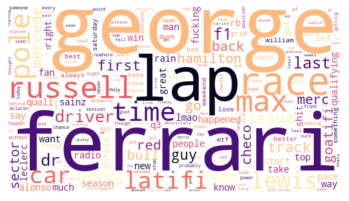

In [86]:
# most common keywords

import numpy as np
from os import path
import os
from PIL import Image

text_combined = ' '.join(df_posts['text_clean'])

#Creating a mask
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "mercedespngf1.png")))


wc = WordCloud(width=1600, height=1200, mask = mask, max_font_size=120,
               background_color = 'White', colormap = 'magma_r', 
               collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [57]:
# extract keyword counts
kwords = WordCloud().process_text(text_combined)
kwords

{'welcome': 5,
 'discussion': 2,
 'q': 8,
 'thread': 13,
 'hub': 1,
 'general': 8,
 'formula': 19,
 'new': 108,
 'place': 46,
 'wondered': 1,
 'called': 15,
 'lollipop': 2,
 'man': 109,
 'refuel': 2,
 'mika': 3,
 'back': 134,
 'sabbatical': 1,
 'ask': 12,
 'question': 30,
 'might': 79,
 'community': 2,
 'answer': 10,
 'sure': 66,
 'check': 15,
 'guide': 2,
 'faq': 1,
 'veteran': 2,
 'fan': 90,
 'longing': 1,
 'men': 3,
 'refueling': 1,
 'hkkinen': 2,
 'introduce': 2,
 'passion': 1,
 'knowledge': 1,
 'sport': 33,
 'remember': 28,
 'keep': 42,
 'civil': 1,
 'welcoming': 2,
 'gatekeeping': 1,
 'within': 16,
 'subject': 1,
 'disciplinary': 1,
 'action': 37,
 'meta': 1,
 'subreddit': 3,
 'please': 44,
 'direct': 7,
 'moderators': 3,
 'instead': 10,
 'discord': 2,
 'support': 8,
 'today': 83,
 'random': 7,
 'f1': 198,
 'closest': 2,
 'finish': 18,
 'recorded': 3,
 'monza': 2,
 'peter': 1,
 'gethin': 1,
 'ronnie': 1,
 'peterson': 1,
 'top': 94,
 'five': 4,
 'finishers': 1,
 'covered': 3,
 'nu

In [58]:
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')
df_kwords.sort_values(by = 'count', ascending = False).head(30)

,count
keyword,
ferrari,397
max,328
george,296
race,294
car,276
lap,273
latifi,263
driver,257
time,249


<AxesSubplot:xlabel='keyword'>

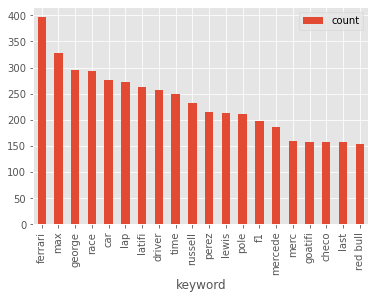

In [95]:
# plot a bar chart with the top keywords
%matplotlib inline
df_kwords.sort_values(by='count', ascending=False).head(20).plot.bar()

### Phrases analysis

In [60]:
# NLTK collocations search (words occuring together): bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

In [61]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [62]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('formula', '1'), 12),
 (('new', 'fans'), 3),
 (('useful', 'links'), 3),
 (('causes', 'support'), 3),
 (('support', 'unicef'), 3),
 (('unicef', 'emergency'), 3),
 (('emergency', 'appeal'), 3),
 (('appeal', 'ukraine'), 3),
 (('f1', 'drivers'), 8),
 (('helmut', 'marko'), 4),
 (('race', 'day'), 9),
 (('24', 'hours'), 3),
 (('alfa', 'romeo'), 4),
 (('2022', 'hungarian'), 4),
 (('grand', 'prix'), 14),
 (('lewis', 'hamilton'), 13),
 (('lando', 'norris'), 4),
 (('hungarian', 'gp'), 7),
 (('aston', 'martin'), 21),
 (('rear', 'wing'), 10),
 (('rain', 'quali'), 5),
 (('last', 'time'), 12),
 (('fans', 'want'), 3),
 (('red', 'bull'), 135),
 (('race', 'would'), 4),
 (('would', 'like'), 10),
 (('engine', 'manufacturers'), 4),
 (('f1', 'history'), 4),
 (('anyone', 'know'), 6),
 (('know', 'happened'), 6),
 (('qualifying', 'lap'), 3),
 (('much', 'better'), 8),
 (('merch', 'burning'), 3),
 (('said', 'something'), 4),
 (('max', 'might'), 3),
 (('w', 'series'), 9),
 (('know', 'f1'), 3),
 (('f1', 'ca'), 

In [63]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq

,count
keyphrase,
red bull,135
drs issue,86
george russell,79
purple sector,53
type guy,51
...,...
new fans,3
right right,3
probably get,3


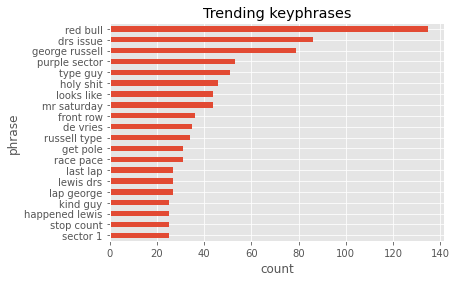

In [91]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()

In [78]:
from textblob import TextBlob

In [79]:
# sentiment analysis


def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_posts['polarity'] = df_posts['text_clean'].apply(sentim_polarity)
df_posts['subjectivity'] = df_posts['text_clean'].apply(sentim_subject)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
0,Ask /r/formula1 Anything - Daily Discussion - ...,wbrcdp,#Welcome to the /r/formula1 Daily Discussion /...,Looks like its not going to rain during quali....,There is a massive rain front passing through ...,welcome daily discussion q thread thread hub g...,0.078802,0.473929
1,2022 Hungarian Grand Prix - Post Qualifying Di...,wbzfoy,### ROUND 13: Hungary 🇭🇺\n\n|FORMULA 1 MAGYAR ...,I do NOT understand Mercedes this year. Big br...,"That’s ok, nobody in Mercedes does either. Not...",round 13 hungary 1 magyar nagydj 29 jul sun 31...,0.083024,0.522585
2,[Chris Medland] Here he comes... LATIFI GOES Q...,wbvylx,,His best finish before this in free practice t...,I flipped on practice and Sky was showing the ...,best finish free practice 12th goes pulls fina...,0.161747,0.503449
3,Nicholas Latifi team radio - 2022 Hungarian GP...,wbw7im,,He seems like a good guy. Let him enjoy this m...,He does seem nice and as a Canadian I much pre...,seems like guy let enjoy moment jokes apart tw...,0.177915,0.570254
4,George Russell takes pole position for the 202...,wbzlsa,,Can't throw away the win from pole if you star...,I was gonna comment the exact same thing. Lecl...,ca throw away win pole start 2nd 3rd ferrari m...,0.194787,0.562170
5,2022 Hungarian Grand Prix - Free Practice 3 Re...,wbw3e3,,Williams sandbagging all season? 😅 NICKY'S ON ...,This is the last race before Latifi is mathema...,williams sandbagging season nicky fire charles...,0.116779,0.534200
6,"Q3: RUSSELL ON POLE, Sainz P2, Leclerc P3",wbzgw7,,So where the fuck did that come from? The no p...,Equivalent exchange with Latifi. Couldn't let ...,come purple pole holy shit expecting blimey he...,0.123835,0.568691
7,2022 Hungarian Grand Prix - Qualifying Results,wbzk5k,,Latifi getting a purple sector one was like Ca...,"A glimpse of his powers, he will reveal his tr...",latifi getting purple sector like captain amer...,0.122633,0.496073
8,FP3: Charles Leclerc 360 spin,wbvv9o,,What is it with him and doing a perfect 360? T...,that's why is called free practice :P Martin B...,perfect 360 dude getting catching spins except...,0.202008,0.524106
9,[Phillip Horton] Sessions topped in 2022: Nich...,wbwxf2,,Lewis to Latifi before Hungary FP3: What’s a p...,Haha >\tWhat’s a king to a ~~God~~***GOAT***? ...,lewis latifi hungary fp3 whats peasant king go...,0.028020,0.533164


### Sentiment Analyisis

In [93]:
# Analysing most commong words and Bigrams Sentiments*
# *Including Brazil because it is my country and one of the favorites to win the World Cup
keywords_analysis = ['red bull', 'ferrari' , 'mercedes', 'george russel', 'verstappen']
keywords_analysis_df = pd.DataFrame(keywords_analysis, 
                                    columns = ['KeyWords'])

# Defining the function to analyze the sentiment on the keywords
def words_sentiment(w):
    return df_posts[df_posts['text_clean'].str.contains(w)]['polarity'].mean()

# Keywords sentiment comparison
keywords_analysis_df['average_sentiment'] = keywords_analysis_df ['KeyWords'].apply(words_sentiment)
keywords_analysis_df

,KeyWords,average_sentiment
0,red bull,0.097934
1,ferrari,0.113239
2,mercedes,0.108574
3,george russel,0.114708
4,verstappen,0.098340
